In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import torch.nn.functional as F
from torchvision import transforms as T
from glob import glob
import cv2
import matplotlib.patches as patches

In [2]:
TRAIN_DATA_PATH = './train_images/'
TEST_DATA_PATH = './test_images/'

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [3]:
PATIENT_LIST = os.listdir(TRAIN_DATA_PATH)
PATIENT_LIST = [f'{TRAIN_DATA_PATH}{PATIENT_LIST[i]}/' for i in range(len(PATIENT_LIST))]
len(PATIENT_LIST), PATIENT_LIST[0]


(11913, './train_images/10006/')

In [4]:
def get_image_list(patient_path: str):
    images_list = glob(f'{patient_path}*.png')
    return images_list

In [5]:
def crop_coords(img):
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return (x, y, w, h)


def truncation_normalization(img):
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized


def clahe(img, clip):
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

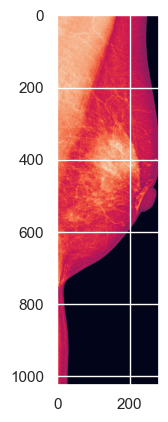

In [6]:
img = cv2.imread(get_image_list(PATIENT_LIST[0])[0], cv2.IMREAD_GRAYSCALE)
(x, y, w, h) = crop_coords(img)

rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

img_cropped = img[y:y+h, x:x+w]

plt.imshow(img_cropped)

In [9]:
TRAIN_PROCESSED = './train_processed/'

In [25]:
IMG_SIZE = 1024

for patient in PATIENT_LIST: 
    for img_path in get_image_list(patient):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        (x, y, w, h) = crop_coords(img)
        
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        
        img_cropped = img[y:y+h, x:x+w]
        
        img_normalized = truncation_normalization(img_cropped)
        cl1 = clahe(img_normalized, 1.0)
        cl2 = clahe(img_normalized, 2.0)
        img_final = cv2.merge((np.array(img_normalized*255, dtype=np.uint8),cl1,cl2))

        # 이미지 반전 
        #img_final = img_final.max() - img_final


        img_final = cv2.resize(img_final, (IMG_SIZE, IMG_SIZE))
        
        patient_id = img_path.split('\\')[0].split('/')[2] + '/'
        img_num = img_path.split('\\')[1]
        
        if not os.path.exists(f'{TRAIN_PROCESSED}{patient_id}'):
            os.makedirs(f'{TRAIN_PROCESSED}{patient_id}') 
        cv2.imwrite(f'{TRAIN_PROCESSED}{patient_id}{img_num}', img_final)
        test_size += 1